In [17]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
df = pd.read_csv("../logs/cross_period_evaluation_results.csv")


#mean across seeds
avg_stats = (
    df.groupby(["train_year", "test_year"], as_index=False)[["accuracy", "f1_score", "auc"]]
    .mean()
)

#cross_accuracy = avg_stats[]

#standard deviation across seeds
std_stats = (
    df.groupby(["train_year", "test_year"])[["accuracy", "f1_score", "auc"]]
    .std()
)

#aggiungi test sullo stesso anno

Aggregating stats

In [19]:
cross_year_df = avg_stats.sort_values(by=['train_year', 'test_year'])

models = ["svm"]
base_dir = Path("models_avg_results")

for model in models:
    model_file = base_dir / f"tfidf_{model}_performance_avg.csv"
    df = pd.read_csv(model_file)
    avg_stats_same_year = df[["year", "accuracy"]]

same_year_df = pd.DataFrame({
    'train_year': avg_stats_same_year['year'],
    'test_year': avg_stats_same_year['year'],  # Use 'year' for both train and test
    'accuracy': avg_stats_same_year['accuracy'],
    'f1_score': np.nan,  # update with all the data if you want
    'auc': np.nan
})

final_df = pd.concat([cross_year_df, same_year_df], ignore_index=True).sort_values(by=["train_year", "test_year"])
print(final_df)


      train_year  test_year  accuracy  f1_score       auc
1260          76         76  0.539267       NaN       NaN
0             76         77  0.531833  0.529167  0.550233
1             76         78  0.523000  0.518833  0.547300
2             76         79  0.549033  0.541133  0.580367
3             76         80  0.499433  0.494000  0.539467
...          ...        ...       ...       ...       ...
1256         111        107  0.501800  0.513500  0.550833
1257         111        108  0.510133  0.529133  0.546900
1258         111        109  0.508400  0.535033  0.576400
1259         111        110  0.624700  0.640133  0.739800
1295         111        111  0.747233       NaN       NaN

[1296 rows x 5 columns]


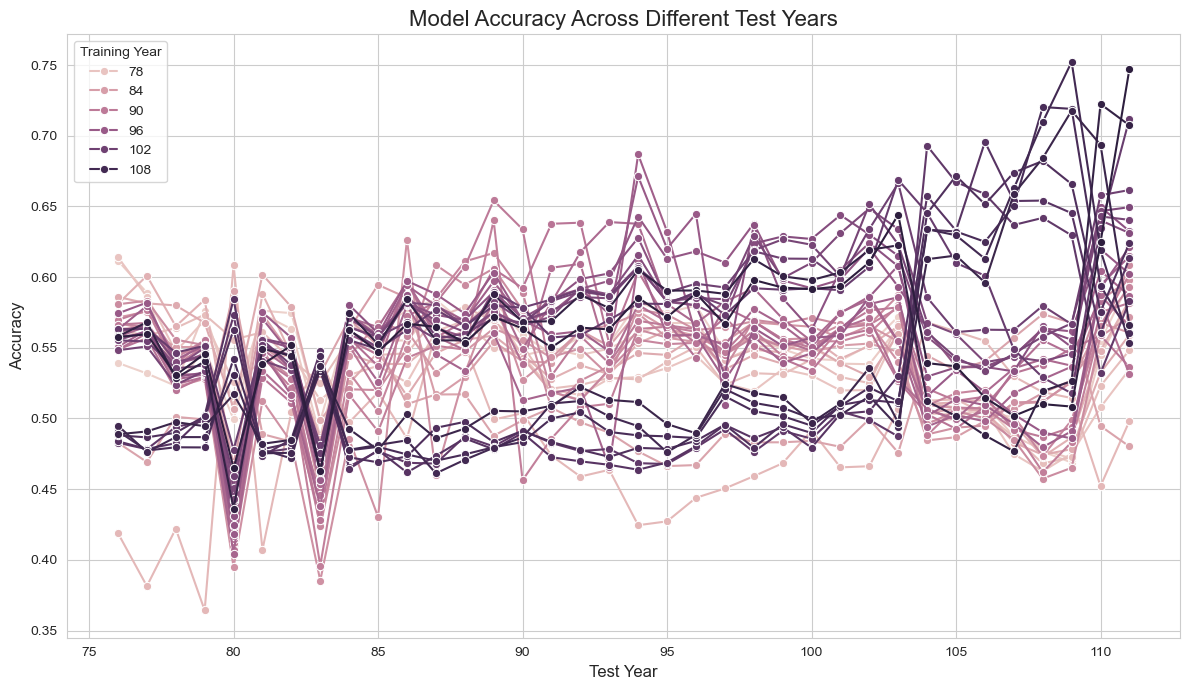

In [20]:

# Now, plot directly from your DataFrame
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

sns.lineplot(
    data=final_df,      #<-- Use your DataFrame here
    x='test_year',
    y='accuracy',
    hue='train_year',    #<-- This creates a line for each training year
    marker='o'
)

# Add titles and labels for clarity
plt.title('Model Accuracy Across Different Test Years', fontsize=16)
plt.xlabel('Test Year', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(title='Training Year')
plt.tight_layout()
plt.show()



In [21]:
create_summary_stats(final_df)

{'Best Performance': {'Accuracy': '0.7522',
  'Train Year': 108,
  'Test Year': 109,
  'Time Gap': 1},
 'Worst Performance': {'Accuracy': '0.3643',
  'Train Year': 80,
  'Test Year': 79,
  'Time Gap': -1},
 'Same Year Performance': {'Mean Accuracy': '0.6248',
  'Std Accuracy': '0.0503',
  'Count': 36},
 'Cross Year Performance': {'Mean Accuracy': '0.5423',
  'Std Accuracy': '0.0497',
  'Count': 1260}}

Generating model performance analysis...

Creating heatmap...


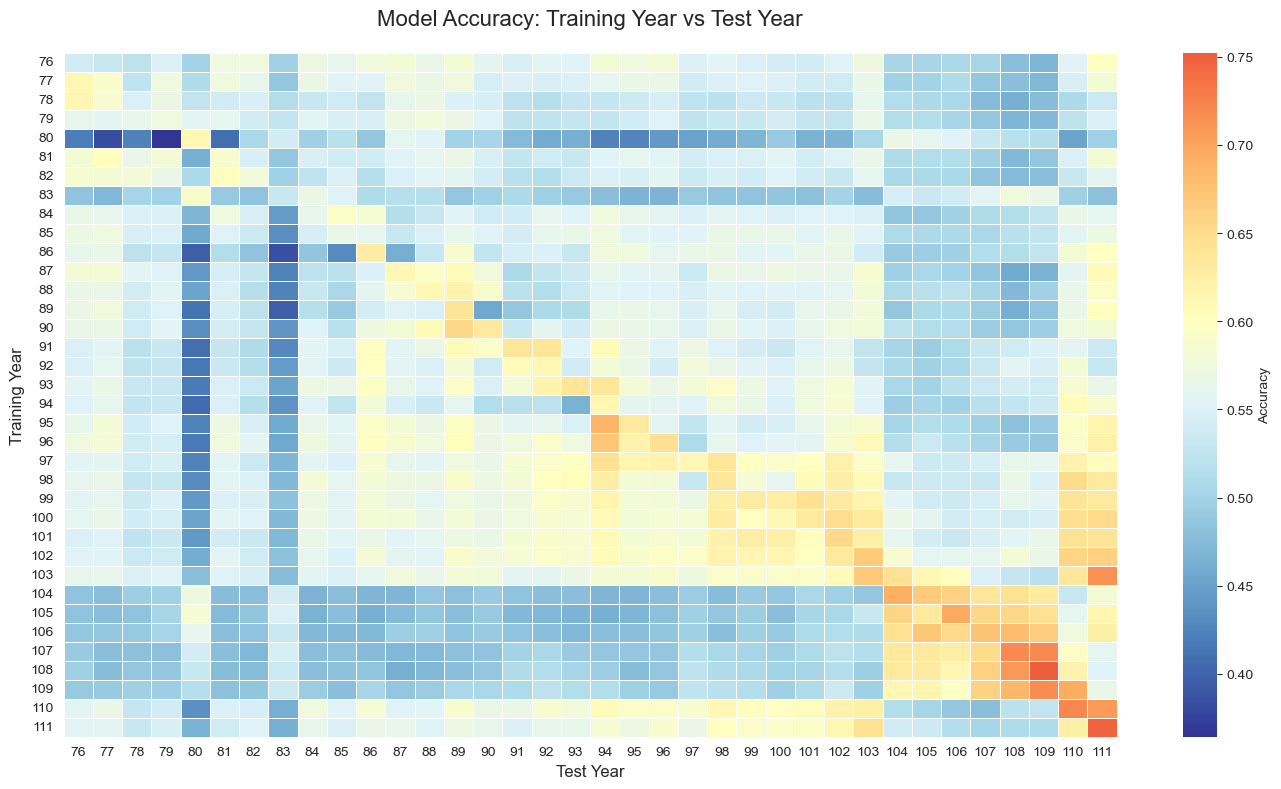

Creating performance trends...


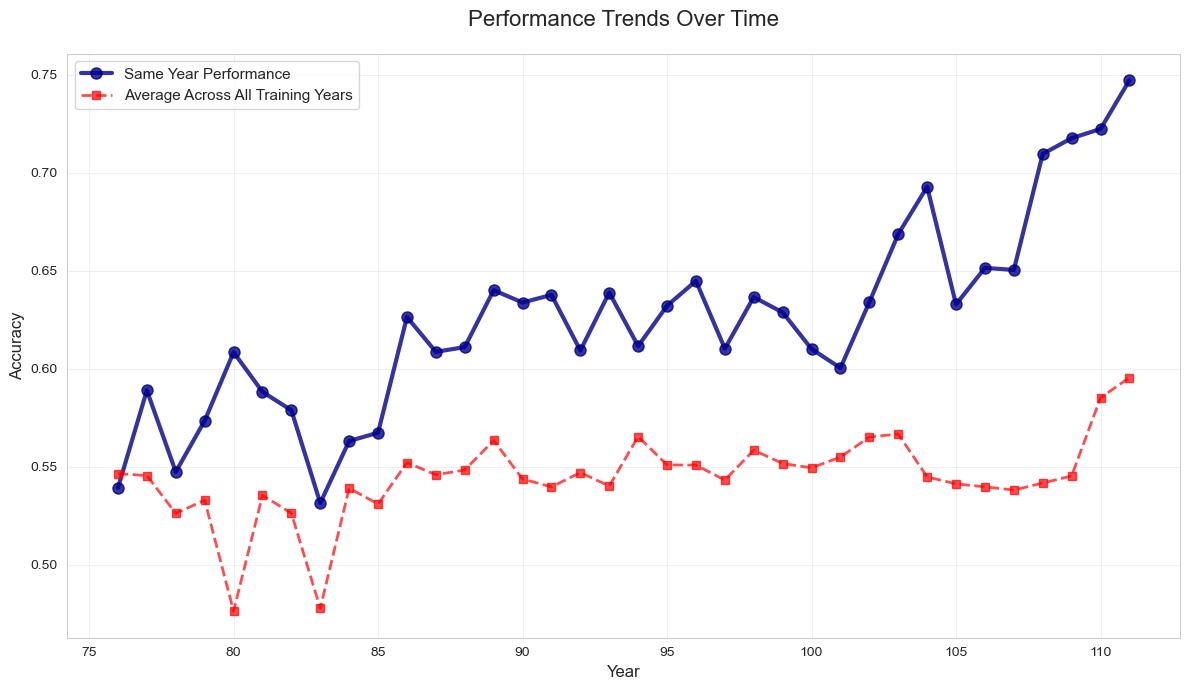

Generating summary statistics...
MODEL PERFORMANCE SUMMARY

🏆 BEST PERFORMANCE:
   Accuracy: 0.7522
   Train Year: 108
   Test Year: 109
   Time Gap: 1 years

📉 WORST PERFORMANCE:
   Accuracy: 0.3643
   Train Year: 80
   Test Year: 79
   Time Gap: -1 years

📊 SAME YEAR vs CROSS YEAR COMPARISON:
   Same Year - Mean: 0.6248 (±0.0503)
   Cross Year - Mean: 0.5423 (±0.0497)
   Performance Gap: 0.0825 (15.2% higher for same year)


In [22]:
def create_heatmap(df):
    """Create a heatmap showing training year vs test year performance"""
    # Pivot the data to create a matrix
    pivot_df = df.pivot(index='train_year', columns='test_year', values='accuracy')
    
    plt.figure(figsize=(14, 8))
    sns.heatmap(pivot_df, 
                annot=False, 
                fmt='.3f', 
                cmap='RdYlBu_r',  # Red-Yellow-Blue reversed (higher values are blue)
                center=0.6,  # Adjust based on your data range
                cbar_kws={'label': 'Accuracy'},
                linewidths=0.5)
    
    plt.title('Model Accuracy: Training Year vs Test Year', fontsize=16, pad=20)
    plt.xlabel('Test Year', fontsize=12)
    plt.ylabel('Training Year', fontsize=12)
    plt.tight_layout()
    return plt

def create_performance_trends(df):
    """Create performance trends showing same-year vs cross-year performance"""
    plt.figure(figsize=(12, 7))
    
    # Same year performance (diagonal elements)
    same_year_perf = df[df['train_year'] == df['test_year']].copy()
    if not same_year_perf.empty:
        plt.plot(same_year_perf['train_year'], same_year_perf['accuracy'], 
                'o-', label='Same Year Performance', linewidth=3, markersize=8, 
                color='darkblue', alpha=0.8)
    
    # Average performance for each test year across all training years
    avg_perf = df.groupby('test_year')['accuracy'].mean().reset_index()
    plt.plot(avg_perf['test_year'], avg_perf['accuracy'], 
            's--', label='Average Across All Training Years', 
            linewidth=2, markersize=6, color='red', alpha=0.7)
    
    plt.title('Performance Trends Over Time', fontsize=16, pad=20)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt

def create_summary_stats(df):
    """Create summary statistics focusing on best and worst performance"""
    
    # Find best and worst performance
    best_idx = df['accuracy'].idxmax()
    worst_idx = df['accuracy'].idxmin()
    
    best_performance = df.loc[best_idx]
    worst_performance = df.loc[worst_idx]
    
    # Same-year performance stats
    same_year = df[df['train_year'] == df['test_year']].copy()
    
    # Cross-year performance stats (excluding same year)
    cross_year = df[df['train_year'] != df['test_year']].copy()
    
    summary_stats = {
        'Best Performance': {
            'Accuracy': f"{best_performance['accuracy']:.4f}",
            'Train Year': int(best_performance['train_year']),
            'Test Year': int(best_performance['test_year']),
            'Time Gap': int(best_performance['test_year'] - best_performance['train_year'])
        },
        'Worst Performance': {
            'Accuracy': f"{worst_performance['accuracy']:.4f}",
            'Train Year': int(worst_performance['train_year']),
            'Test Year': int(worst_performance['test_year']),
            'Time Gap': int(worst_performance['test_year'] - worst_performance['train_year'])
        },
        'Same Year Performance': {
            'Mean Accuracy': f"{same_year['accuracy'].mean():.4f}" if not same_year.empty else "N/A",
            'Std Accuracy': f"{same_year['accuracy'].std():.4f}" if not same_year.empty else "N/A",
            'Count': len(same_year)
        },
        'Cross Year Performance': {
            'Mean Accuracy': f"{cross_year['accuracy'].mean():.4f}" if not cross_year.empty else "N/A",
            'Std Accuracy': f"{cross_year['accuracy'].std():.4f}" if not cross_year.empty else "N/A",
            'Count': len(cross_year)
        }
    }
    
    return summary_stats

def print_summary_table(summary_stats):
    """Print a formatted summary table"""
    print("="*60)
    print("MODEL PERFORMANCE SUMMARY")
    print("="*60)
    
    print(f"\n🏆 BEST PERFORMANCE:")
    print(f"   Accuracy: {summary_stats['Best Performance']['Accuracy']}")
    print(f"   Train Year: {summary_stats['Best Performance']['Train Year']}")
    print(f"   Test Year: {summary_stats['Best Performance']['Test Year']}")
    print(f"   Time Gap: {summary_stats['Best Performance']['Time Gap']} years")
    
    print(f"\n📉 WORST PERFORMANCE:")
    print(f"   Accuracy: {summary_stats['Worst Performance']['Accuracy']}")
    print(f"   Train Year: {summary_stats['Worst Performance']['Train Year']}")
    print(f"   Test Year: {summary_stats['Worst Performance']['Test Year']}")
    print(f"   Time Gap: {summary_stats['Worst Performance']['Time Gap']} years")
    
    print(f"\n📊 SAME YEAR vs CROSS YEAR COMPARISON:")
    print(f"   Same Year - Mean: {summary_stats['Same Year Performance']['Mean Accuracy']} (±{summary_stats['Same Year Performance']['Std Accuracy']})")
    print(f"   Cross Year - Mean: {summary_stats['Cross Year Performance']['Mean Accuracy']} (±{summary_stats['Cross Year Performance']['Std Accuracy']})")
    
    # Calculate performance difference
    if (summary_stats['Same Year Performance']['Mean Accuracy'] != "N/A" and 
        summary_stats['Cross Year Performance']['Mean Accuracy'] != "N/A"):
        same_year_mean = float(summary_stats['Same Year Performance']['Mean Accuracy'])
        cross_year_mean = float(summary_stats['Cross Year Performance']['Mean Accuracy'])
        difference = same_year_mean - cross_year_mean
        print(f"   Performance Gap: {difference:.4f} ({difference/cross_year_mean*100:.1f}% higher for same year)")
    
    print("="*60)

def analyze_model_performance(df):
    """Complete analysis workflow"""
    print("Generating model performance analysis...\n")
    
    # Create visualizations
    print("Creating heatmap...")
    create_heatmap(df)
    plt.show()
    
    print("Creating performance trends...")
    create_performance_trends(df)
    plt.show()
    
    # Generate and display summary statistics
    print("Generating summary statistics...")
    summary_stats = create_summary_stats(df)
    print_summary_table(summary_stats)
    
    return summary_stats

# Usage example:
if __name__ == "__main__":
    # Assuming you have your final_df ready
    # final_df should have columns: train_year, test_year, accuracy
    
    # Run complete analysis
    summary = analyze_model_performance(final_df)
    
    # You can also run individual components:
    # create_heatmap(final_df)
    # plt.show()
    # 
    # create_performance_trends(final_df)
    # plt.show()
    # 
    # summary = create_summary_stats(final_df)
    # print_summary_table(summary)

Generating performance gap analysis...



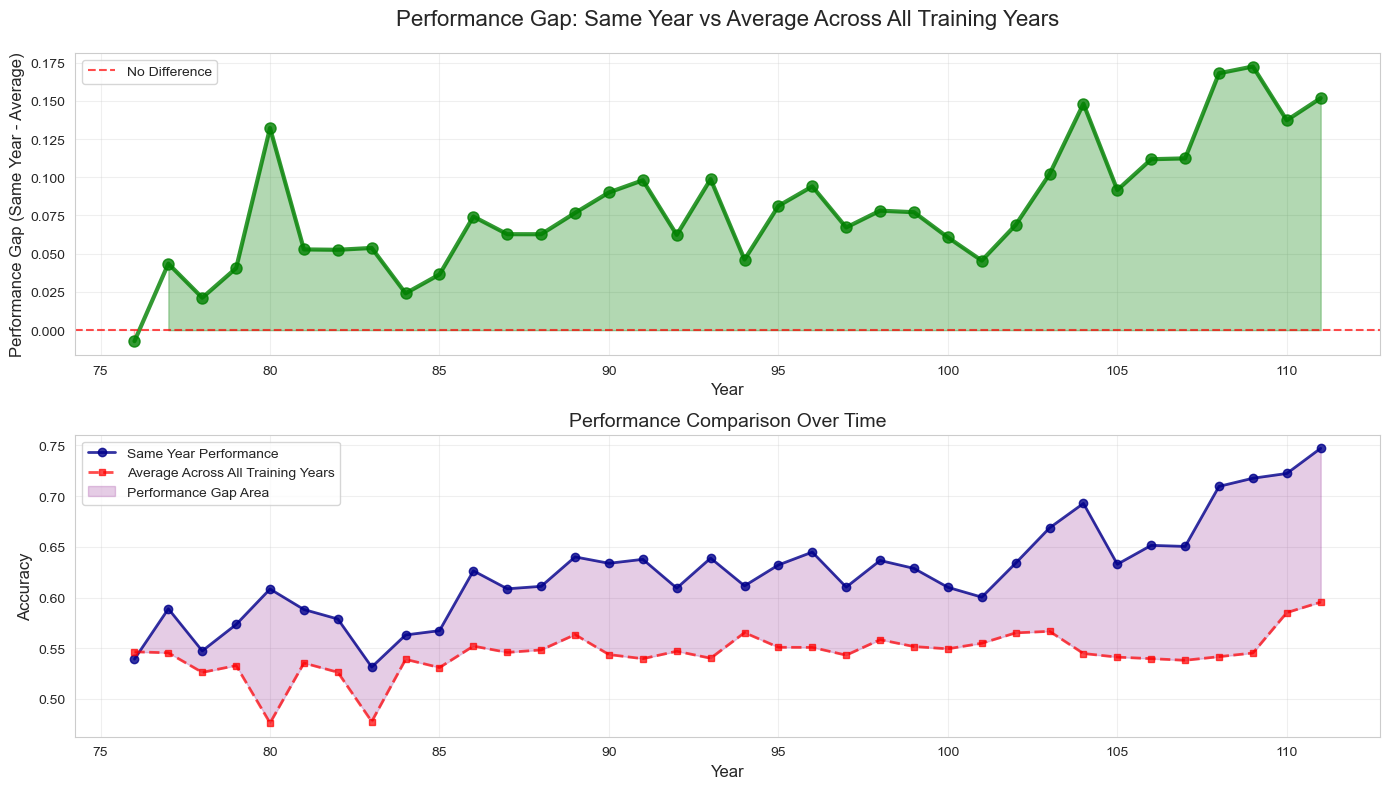

PERFORMANCE GAP ANALYSIS

📊 GAP STATISTICS:
   Mean Gap: 0.0803
   Standard Deviation: 0.0417
   Maximum Gap: 0.1724 (Year 109)
   Minimum Gap: -0.0072 (Year 76)

🔍 GAP DISTRIBUTION:
   Years with Positive Gap: 35 (Same year performs better)
   Years with Negative Gap: 1 (Average performs better)
   Years with No Gap: 0
   Percentage Positive: 97.2%
   Percentage Negative: 2.8%

Gap data preview:
   train_year  accuracy_same_year  accuracy_avg_all  performance_gap
0          76            0.539267          0.546494        -0.007227
1          77            0.588933          0.545452         0.043481
2          78            0.547367          0.526178         0.021189
3          79            0.573467          0.532907         0.040559
4          80            0.608433          0.476255         0.132179


In [23]:
def create_performance_gap_analysis(df):
    """Create a graph showing the absolute difference between same-year and cross-year performance"""
    
    # Calculate same year performance (diagonal elements)
    same_year_perf = df[df['train_year'] == df['test_year']].copy()
    
    # Calculate average performance for each test year across all training years
    avg_perf = df.groupby('test_year')['accuracy'].mean().reset_index()
    
    # Merge to get both metrics for each year
    merged_data = same_year_perf.merge(avg_perf, left_on='train_year', right_on='test_year', 
                                       suffixes=('_same_year', '_avg_all'))
    
    # Calculate absolute difference
    merged_data['performance_gap'] = merged_data['accuracy_same_year'] - merged_data['accuracy_avg_all']
    
    # Create the plot
    plt.figure(figsize=(14, 8))
    
    # Main plot: Performance gap over time
    plt.subplot(2, 1, 1)
    plt.plot(merged_data['train_year'], merged_data['performance_gap'], 
             'o-', linewidth=3, markersize=8, color='green', alpha=0.8)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='No Difference')
    plt.fill_between(merged_data['train_year'], merged_data['performance_gap'], 0, 
                     alpha=0.3, color='green', where=(merged_data['performance_gap'] > 0))
    plt.fill_between(merged_data['train_year'], merged_data['performance_gap'], 0, 
                     alpha=0.3, color='red', where=(merged_data['performance_gap'] < 0))
    
    plt.title('Performance Gap: Same Year vs Average Across All Training Years', fontsize=16, pad=20)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Performance Gap (Same Year - Average)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Secondary plot: Both lines for context
    plt.subplot(2, 1, 2)
    plt.plot(merged_data['train_year'], merged_data['accuracy_same_year'], 
             'o-', label='Same Year Performance', linewidth=2, markersize=6, 
             color='darkblue', alpha=0.8)
    plt.plot(merged_data['train_year'], merged_data['accuracy_avg_all'], 
             's--', label='Average Across All Training Years', 
             linewidth=2, markersize=5, color='red', alpha=0.7)
    
    # Fill the area between the lines
    plt.fill_between(merged_data['train_year'], 
                     merged_data['accuracy_same_year'], 
                     merged_data['accuracy_avg_all'], 
                     alpha=0.2, color='purple', label='Performance Gap Area')
    
    plt.title('Performance Comparison Over Time', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return plt, merged_data

def create_gap_statistics(merged_data):
    """Generate statistics about the performance gap"""
    
    gap_stats = {
        'Mean Gap': merged_data['performance_gap'].mean(),
        'Std Gap': merged_data['performance_gap'].std(),
        'Max Gap': merged_data['performance_gap'].max(),
        'Min Gap': merged_data['performance_gap'].min(),
        'Max Gap Year': merged_data.loc[merged_data['performance_gap'].idxmax(), 'train_year'],
        'Min Gap Year': merged_data.loc[merged_data['performance_gap'].idxmin(), 'train_year'],
        'Positive Gap Count': (merged_data['performance_gap'] > 0).sum(),
        'Negative Gap Count': (merged_data['performance_gap'] < 0).sum(),
        'Zero Gap Count': (merged_data['performance_gap'] == 0).sum()
    }
    
    return gap_stats

def print_gap_analysis(gap_stats):
    """Print formatted gap analysis results"""
    print("="*60)
    print("PERFORMANCE GAP ANALYSIS")
    print("="*60)
    
    print(f"\n📊 GAP STATISTICS:")
    print(f"   Mean Gap: {gap_stats['Mean Gap']:.4f}")
    print(f"   Standard Deviation: {gap_stats['Std Gap']:.4f}")
    print(f"   Maximum Gap: {gap_stats['Max Gap']:.4f} (Year {int(gap_stats['Max Gap Year'])})")
    print(f"   Minimum Gap: {gap_stats['Min Gap']:.4f} (Year {int(gap_stats['Min Gap Year'])})")
    
    print(f"\n🔍 GAP DISTRIBUTION:")
    print(f"   Years with Positive Gap: {gap_stats['Positive Gap Count']} (Same year performs better)")
    print(f"   Years with Negative Gap: {gap_stats['Negative Gap Count']} (Average performs better)")
    print(f"   Years with No Gap: {gap_stats['Zero Gap Count']}")
    
    total_years = gap_stats['Positive Gap Count'] + gap_stats['Negative Gap Count'] + gap_stats['Zero Gap Count']
    if total_years > 0:
        pos_percentage = (gap_stats['Positive Gap Count'] / total_years) * 100
        neg_percentage = (gap_stats['Negative Gap Count'] / total_years) * 100
        print(f"   Percentage Positive: {pos_percentage:.1f}%")
        print(f"   Percentage Negative: {neg_percentage:.1f}%")
    
    print("="*60)

def analyze_performance_gap(df):
    """Complete performance gap analysis workflow"""
    print("Generating performance gap analysis...\n")
    
    # Create the gap visualization
    plt_obj, merged_data = create_performance_gap_analysis(df)
    plt.show()
    
    # Generate and display gap statistics
    gap_stats = create_gap_statistics(merged_data)
    print_gap_analysis(gap_stats)
    
    return merged_data, gap_stats

# Usage example:
if __name__ == "__main__":
    # Assuming you have your final_df ready
    # final_df should have columns: train_year, test_year, accuracy
    
    # Run the gap analysis
    gap_data, gap_statistics = analyze_performance_gap(final_df)
    
    # You can also access the gap data for further analysis
    print("\nGap data preview:")
    print(gap_data[['train_year', 'accuracy_same_year', 'accuracy_avg_all', 'performance_gap']].head())

Preparing time gap analysis...

Creating time gap analysis plots...


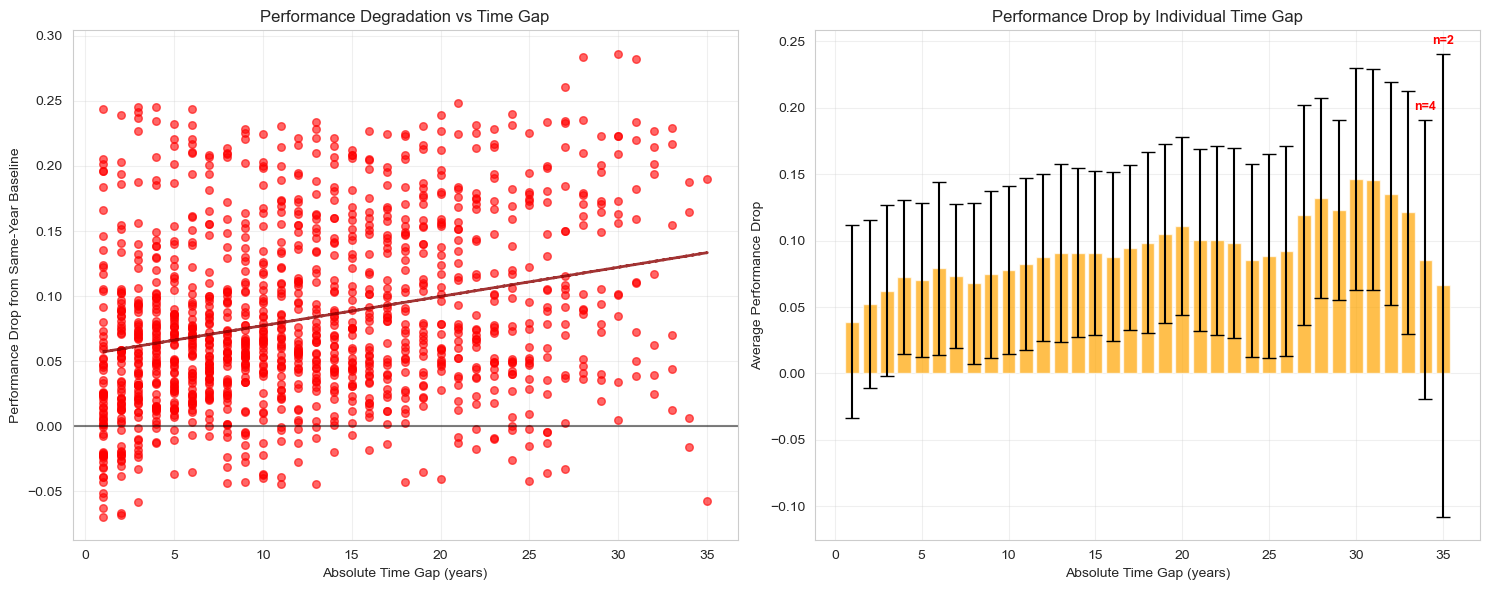

Individual gap analysis results...
GAP ANALYSIS RESULTS (Individual Time Gaps)
 Time_Gap  Avg_Performance_Drop  Std_Performance_Drop  Sample_Count  Avg_Accuracy
        1                0.0389                0.0727            70        0.5854
        2                0.0522                0.0633            68        0.5712
        3                0.0623                0.0646            66        0.5608
        4                0.0726                0.0581            64        0.5500
        5                0.0703                0.0579            62        0.5520
        6                0.0790                0.0652            60        0.5434
        7                0.0731                0.0543            58        0.5498
        8                0.0679                0.0606            56        0.5555
        9                0.0746                0.0628            54        0.5490
       10                0.0778                0.0631            52        0.5467
       11          

In [24]:
def prepare_gap_analysis(df):
    """Prepare data for time gap analysis with same-year baseline"""
    df_analysis = df.copy()
    
    # Calculate absolute time gap
    df_analysis['abs_time_gap'] = np.abs(df_analysis['test_year'] - df_analysis['train_year'])
    
    # Get same-year performance as baseline for each year
    same_year_baseline = df[df['train_year'] == df['test_year']].set_index('train_year')['accuracy']
    
    # For cross-year combinations, calculate performance drop from same-year baseline
    df_analysis['baseline_accuracy'] = np.nan
    df_analysis['performance_drop'] = np.nan
    
    for idx, row in df_analysis.iterrows():
        train_year = row['train_year']
        test_year = row['test_year']
        
        # If same year, performance drop is 0
        if train_year == test_year:
            df_analysis.loc[idx, 'baseline_accuracy'] = row['accuracy']
            df_analysis.loc[idx, 'performance_drop'] = 0.0
        else:
            # Use training year's same-year performance as baseline
            if train_year in same_year_baseline.index:
                baseline = same_year_baseline[train_year]
                df_analysis.loc[idx, 'baseline_accuracy'] = baseline
                df_analysis.loc[idx, 'performance_drop'] = baseline - row['accuracy']
    
    return df_analysis

def create_gap_analysis_plot(df_analysis):
    """Create time gap analysis visualization"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    cross_year_data = df_analysis[df_analysis['abs_time_gap'] > 0]
    
    # 1. Performance Drop vs Time Gap
    ax1 = axes[0]
    valid_drops = cross_year_data.dropna(subset=['performance_drop'])
    
    if not valid_drops.empty:
        ax1.scatter(valid_drops['abs_time_gap'], valid_drops['performance_drop'], 
                   alpha=0.6, s=30, color='red')
        
        # Add trend line for performance drop
        if len(valid_drops) > 1:
            z2 = np.polyfit(valid_drops['abs_time_gap'], valid_drops['performance_drop'], 1)
            p2 = np.poly1d(z2)
            ax1.plot(valid_drops['abs_time_gap'], p2(valid_drops['abs_time_gap']), 
                    "darkred", linestyle='--', alpha=0.8, linewidth=2)
    
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax1.set_xlabel('Absolute Time Gap (years)')
    ax1.set_ylabel('Performance Drop from Same-Year Baseline')
    ax1.set_title('Performance Degradation vs Time Gap')
    ax1.grid(True, alpha=0.3)
    
    # 2. Individual gap analysis (ungrouped)
    ax2 = axes[1]
    
    valid_drops = cross_year_data.dropna(subset=['performance_drop'])
    if not valid_drops.empty:
        # Calculate statistics by individual gap
        gap_stats = valid_drops.groupby('abs_time_gap').agg({
            'performance_drop': ['mean', 'std', 'count'],
            'accuracy': 'mean'
        }).round(4)
        
        gap_stats.columns = ['drop_mean', 'drop_std', 'count', 'acc_mean']
        gap_stats = gap_stats.reset_index()
        
        # Plot with error bars
        ax2.bar(gap_stats['abs_time_gap'], gap_stats['drop_mean'], 
               yerr=gap_stats['drop_std'], 
               alpha=0.7, color='orange', capsize=5)
        
        ax2.set_xlabel('Absolute Time Gap (years)')
        ax2.set_ylabel('Average Performance Drop')
        ax2.set_title('Performance Drop by Individual Time Gap')
        ax2.grid(True, alpha=0.3)
        
        # Add sample size annotations for small samples
        for _, row in gap_stats.iterrows():
            if row['count'] <= 5:  # Only label small sample sizes
                ax2.text(row['abs_time_gap'], 
                        row['drop_mean'] + (row['drop_std'] if pd.notna(row['drop_std']) else 0) + 0.005, 
                        f'n={int(row["count"])}', ha='center', va='bottom', 
                        fontsize=9, color='red', fontweight='bold')
    
    plt.tight_layout()
    return fig, gap_stats if 'gap_stats' in locals() else None

def create_gap_summary_stats(df_analysis):
    """Create summary statistics for time gap analysis"""
    cross_year_data = df_analysis[df_analysis['abs_time_gap'] > 0]
    valid_drops = cross_year_data.dropna(subset=['performance_drop'])
    
    summary = {}
    
    # Overall statistics
    summary['Overall'] = {
        'Total Cross-Year Combinations': len(cross_year_data),
        'Valid Baseline Comparisons': len(valid_drops),
        'Average Performance Drop': f"{valid_drops['performance_drop'].mean():.4f}" if not valid_drops.empty else "N/A",
        'Max Performance Drop': f"{valid_drops['performance_drop'].max():.4f}" if not valid_drops.empty else "N/A",
        'Min Performance Drop': f"{valid_drops['performance_drop'].min():.4f}" if not valid_drops.empty else "N/A"
    }
    
    # Time gap statistics
    gap_stats = cross_year_data['abs_time_gap'].describe()
    summary['Time Gap Distribution'] = {
        'Mean Gap': f"{gap_stats['mean']:.1f} years",
        'Median Gap': f"{gap_stats['50%']:.1f} years",
        'Max Gap': f"{gap_stats['max']:.0f} years",
        'Most Common Gap': f"{cross_year_data['abs_time_gap'].mode().iloc[0]:.0f} years" if not cross_year_data.empty else "N/A"
    }
    
    # Sample size warnings
    gap_counts = cross_year_data['abs_time_gap'].value_counts()
    low_sample_gaps = gap_counts[gap_counts <= 3]
    
    summary['Data Quality'] = {
        'Gaps with ≤3 samples': len(low_sample_gaps),
        'Gaps with single sample': len(gap_counts[gap_counts == 1]),
        'Most reliable gaps (>5 samples)': len(gap_counts[gap_counts > 5])
    }
    
    return summary

def print_gap_analysis_summary(gap_stats):
    """Print formatted summary table with individual gaps"""
    print("="*80)
    print("GAP ANALYSIS RESULTS (Individual Time Gaps)")
    print("="*80)
    
    if gap_stats is not None and not gap_stats.empty:
        # Add a column for better readability
        display_stats = gap_stats.copy()
        display_stats['drop_mean'] = display_stats['drop_mean'].round(4)
        display_stats['drop_std'] = display_stats['drop_std'].round(4)
        display_stats['acc_mean'] = display_stats['acc_mean'].round(4)
        display_stats['count'] = display_stats['count'].astype(int)
        
        # Rename columns for better display
        display_stats.columns = ['Time_Gap', 'Avg_Performance_Drop', 'Std_Performance_Drop', 'Sample_Count', 'Avg_Accuracy']
        
        print(display_stats.to_string(index=False))
        
        # Add summary insights
        print(f"\n📊 SUMMARY INSIGHTS:")
        print(f"   Total unique time gaps: {len(gap_stats)}")
        print(f"   Gaps with only 1 sample: {len(gap_stats[gap_stats['count'] == 1])}")
        print(f"   Gaps with >5 samples: {len(gap_stats[gap_stats['count'] > 5])}")
        print(f"   Maximum performance drop: {gap_stats['drop_mean'].max():.4f} (at {gap_stats.loc[gap_stats['drop_mean'].idxmax(), 'abs_time_gap']:.0f} year gap)")
        print(f"   Minimum performance drop: {gap_stats['drop_mean'].min():.4f} (at {gap_stats.loc[gap_stats['drop_mean'].idxmin(), 'abs_time_gap']:.0f} year gap)")
    else:
        print("No gap analysis data available.")
    
    print("="*80)

def analyze_time_gap_performance(df):
    """Complete time gap analysis workflow"""
    print("Preparing time gap analysis...\n")
    
    # Prepare data
    df_analysis = prepare_gap_analysis(df)
    
    # Create visualizations
    print("Creating time gap analysis plots...")
    fig, gap_stats = create_gap_analysis_plot(df_analysis)
    plt.show()
    
    # Display individual gap statistics
    print("Individual gap analysis results...")
    print_gap_analysis_summary(gap_stats)
    
    return df_analysis, gap_stats

# Usage example:
if __name__ == "__main__":
    # Assuming you have your final_df ready
    # final_df should have columns: train_year, test_year, accuracy
    
    # Run complete time gap analysis
    df_analysis, gap_stats = analyze_time_gap_performance(final_df)